In [21]:
import create_data
import kmeans
import voltage
import os
import importlib
import time
import bpf
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [22]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)
importlib.reload(bpf)

<module 'bpf' from 'C:\\Users\\avigh\\Documents\\python\\VoltageDimentionalReduction\\code\\bpf.py'>

In [23]:
print("Loading Data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

# data = create_data.Data(np.array(X))

Loading Data...


In [24]:
# MNIST Pre-processing

subDivision = {}
summation = {}
count = {}

print("Sorting and averaging...")

for xi, yi in zip(X, y):
    if yi in summation:
        subDivision[yi].append(np.array(xi))
        summation[yi] += np.array(xi)
        count[yi] += 1
    else:
        subDivision[yi] = [np.array(xi)]
        summation[yi] = np.array(xi)
        count[yi] = 1

Sorting and averaging...


In [25]:
# Kmeans sampling equal points from each of the 10 digits

# """
print("Kmeans...")

points = 1000
k = points // 10
data = []

for yi in range(10):
    print(yi)
    
    partitions = kmeans.Partitions(subDivision[yi])
    partitions.k_means(k, seed=time.time())

    data += list(partitions.centers)

data = create_data.Data(data)
# """

"""
for sd in subDivision:
    print(len(subDivision[sd]))

data = create_data.Data(X)
# """


Kmeans...
0
1
2
3
4
5
6
7
8
9


'\nfor sd in subDivision:\n    print(len(subDivision[sd]))\n\ndata = create_data.Data(X)\n# '

In [26]:
# Create the landmarks

# """
landmarks = []
for yi in range(10):
    landmark = voltage.Landmark(-1, 1)

    ignore = []
    while (landmark.index // k != yi):
        ignore.append(landmark.index)

        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)
 
    landmarks.append(landmark)

print(len(data))
print([l.index for l in landmarks])
# """

"""
landmarks = []
for yi in range(10):
    landmark = voltage.Landmark(-1, 1)

    ignore = []
    while (y[landmark.index] != yi):
        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)

        ignore.append(landmark.index)

    landmarks.append(landmark)

print(len(data))
print([l.index for l in landmarks])
# """

1000
[91, 197, 213, 331, 474, 547, 639, 770, 818, 936]


'\nlandmarks = []\nfor yi in range(10):\n    landmark = voltage.Landmark(-1, 1)\n\n    ignore = []\n    while (y[landmark.index] != yi):\n        landmark = voltage.Landmark.createLandmarkClosestTo(data, summation[yi] / count[yi], 1, ignore=ignore)\n\n        ignore.append(landmark.index)\n\n    landmarks.append(landmark)\n\nprint(len(data))\nprint([l.index for l in landmarks])\n# '

In [27]:
print(type(data))
print(isinstance(data, create_data.Data))

<class 'create_data.Data'>
True


In [30]:
importlib.reload(bpf)

print("Parameter Finding...")

cs = []
pgs = []

param_finder = bpf.BestParameterFinder()
param_finder.setKernelParameter(500)
# param_finder.setResistanceToGround(0.1)

for landmark in landmarks:
     c, p_g = param_finder.bestParameterFinder([landmark], data, minBound=0, maxBound=10, granularity=10, epsilon=0.1, approx=100)
     print(c, p_g)
     cs.append(c)
     pgs.append(p_g)

# print(cs)
# print(pgs)

Parameter Finding...
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241
499.99999999999983 1.0512710963760241


In [31]:
print(len(data))
# print(cs)
# print(pgs)
c, p_g = param_finder.bestParameterFinder(landmarks, data, minBound=-10, maxBound=10, granularity=10, epsilon=0.5, approx=100)

1000


In [32]:
print(np.log(c), np.log(p_g))
# c, p_g = cs[1], pgs[1]

6.214608098422191 3.3


In [34]:
voltages = []

for index in range(0, len(landmarks)):
    problem = voltage.Problem(data)
    problem.setKernel(problem.gaussiankernel)
    # problem.setWeights(cs[index])
    problem.setWeights(c)
    problem.addLandmark(landmarks[index])
    # problem.addUniversalGround(pgs[index])
    problem.addUniversalGround(p_g)
    voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=100))

In [35]:
param_finder.visualizations(voltages, "../inputoutput/matplotfigures/MNIST")

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [36]:
problem = voltage.Problem(data)
problem.setKernel(problem.gaussiankernel)
problem.setWeights(np.exp(6))
# problem.setWeights(c)
problem.addLandmark(landmarks[0])
problem.addUniversalGround(0.1)

temp_volts = voltage.Solver(problem).approximate_voltages(max_iters=100)
print(param_finder.nInfExp(temp_volts))
print(param_finder.expWithStd(temp_volts))
print(np.std(temp_volts))

problem.setWeights(np.exp(10))
temp_volts = voltage.Solver(problem).approximate_voltages(max_iters=100)
print(param_finder.nInfExp(temp_volts))
print(param_finder.expWithStd(temp_volts))
print(np.std(temp_volts))

13.258205239518736
188.64312515784638
0.07028194230998339
12.212140222605687
426.96596400921374
0.02860213987066696


In [37]:
print(voltages[0])

[0.06551941 0.11875825 0.06019583 0.0774454  0.17813071 0.12468162
 0.06779863 0.07376774 0.01050847 0.04914911 0.10750009 0.17760514
 0.04126506 0.07350958 0.063234   0.10517135 0.07763815 0.04870776
 0.07987331 0.07743571 0.10532873 0.0849571  0.03034358 0.08402542
 0.06291488 0.09072732 0.10458035 0.16303222 0.16546051 0.05710083
 0.04874251 0.05599987 0.18284756 0.04548125 0.12020264 0.05248247
 0.04798506 0.05975829 0.05635271 0.07550518 0.01181946 0.15791905
 0.04886903 0.07496516 0.08044189 0.06661889 0.04981631 0.05810255
 0.11934981 0.15240582 0.06169534 0.09669164 0.12251995 0.08452666
 0.03355434 0.09010491 0.0917547  0.08827444 0.06161911 0.07416396
 0.07590182 0.0165183  0.12290035 0.0571734  0.10723809 0.08699166
 0.02241149 0.07832995 0.06666492 0.13004707 0.10578792 0.09535978
 0.02810681 0.05019145 0.05562925 0.16487842 0.15235545 0.05582982
 0.04642343 0.06011796 0.05374988 0.160893   0.01661781 0.02553781
 0.1489255  0.18290662 0.05392859 0.09629432 0.05566499 0.0666

In [38]:
print(voltages[1])

[0.04534767 0.03318407 0.04060469 0.03365891 0.04027757 0.03613356
 0.04625985 0.03221237 0.06264119 0.04734065 0.03362611 0.03233159
 0.0463292  0.0352632  0.0468165  0.03678088 0.0341768  0.0432048
 0.04480396 0.03641831 0.03279673 0.04016432 0.05201205 0.0330286
 0.03883203 0.03168752 0.03602702 0.04040586 0.03505071 0.04252116
 0.04876873 0.04613164 0.0373227  0.04784984 0.03631235 0.04048128
 0.04880073 0.04419956 0.03934756 0.03392597 0.05741627 0.04163183
 0.03467637 0.04573192 0.03854573 0.03519    0.0351657  0.03371944
 0.03489861 0.04057953 0.03394268 0.03896557 0.0403466  0.03260799
 0.05081264 0.03913733 0.03154434 0.03169491 0.03355666 0.03298826
 0.0426735  0.0555836  0.03290754 0.04222945 0.04066854 0.04133646
 0.05422232 0.03336187 0.03265879 0.03614848 0.03315068 0.03869437
 0.04409119 0.04749873 0.04394818 0.0348762  0.03390911 0.04439908
 0.04135862 0.03370157 0.03435602 0.03628716 0.05342404 0.05325514
 0.03863523 0.03465327 0.04122769 0.03225823 0.03299178 0.043288

Incorrect predictions: 368/1000
Accuracy: 63.20%
Error Rate: 36.80%


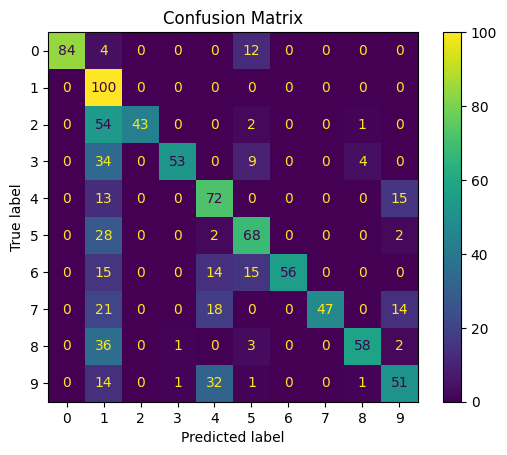

<Figure size 640x480 with 0 Axes>

In [39]:
predicted = np.argmax(voltages, axis=0)
correct = np.repeat(np.arange(10), k)

num_incorrect = np.sum(predicted != correct)

accuracy = np.mean(predicted == correct)
error_rate = 1 - accuracy

print(f"Incorrect predictions: {num_incorrect}/{len(data)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

cm = confusion_matrix(correct, predicted, labels=np.arange(10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
plt.clf()

(1000, 10)


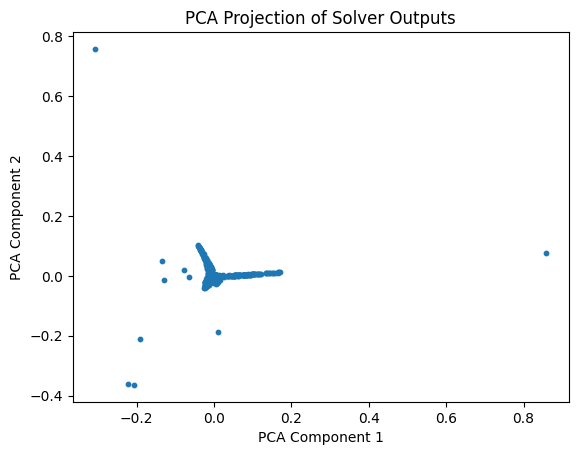

(1000, 2)


<Figure size 640x480 with 0 Axes>

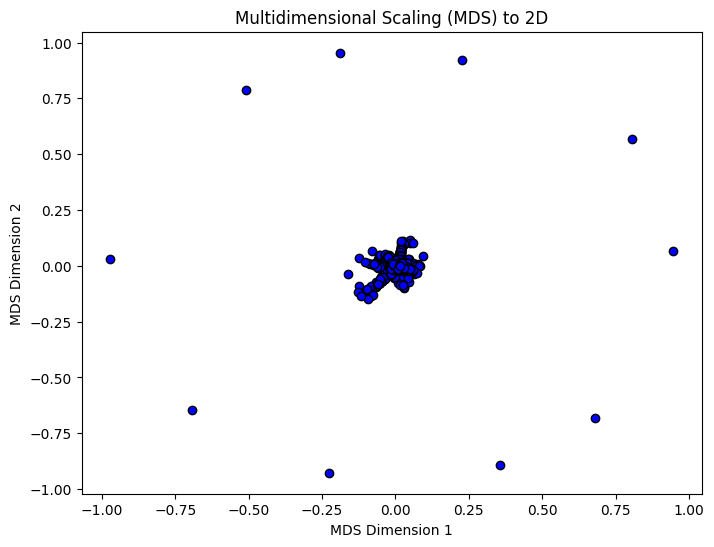

<Figure size 640x480 with 0 Axes>

In [40]:
points = np.array(list(map(list, zip(*voltages))))

print(points.shape)

# PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

# print(points_2d.shape)

plt.scatter(points_2d[:, 0], points_2d[:, 1], s=10)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Solver Outputs")

plt.show()
# plt.savefig(fileStarter + "_PCA.png")
plt.clf()

# MDS
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

print(transformed_points.shape)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Multidimensional Scaling (MDS) to 2D")

# plt.savefig(fileStarter + "_MDS.png")
plt.show()
plt.clf()

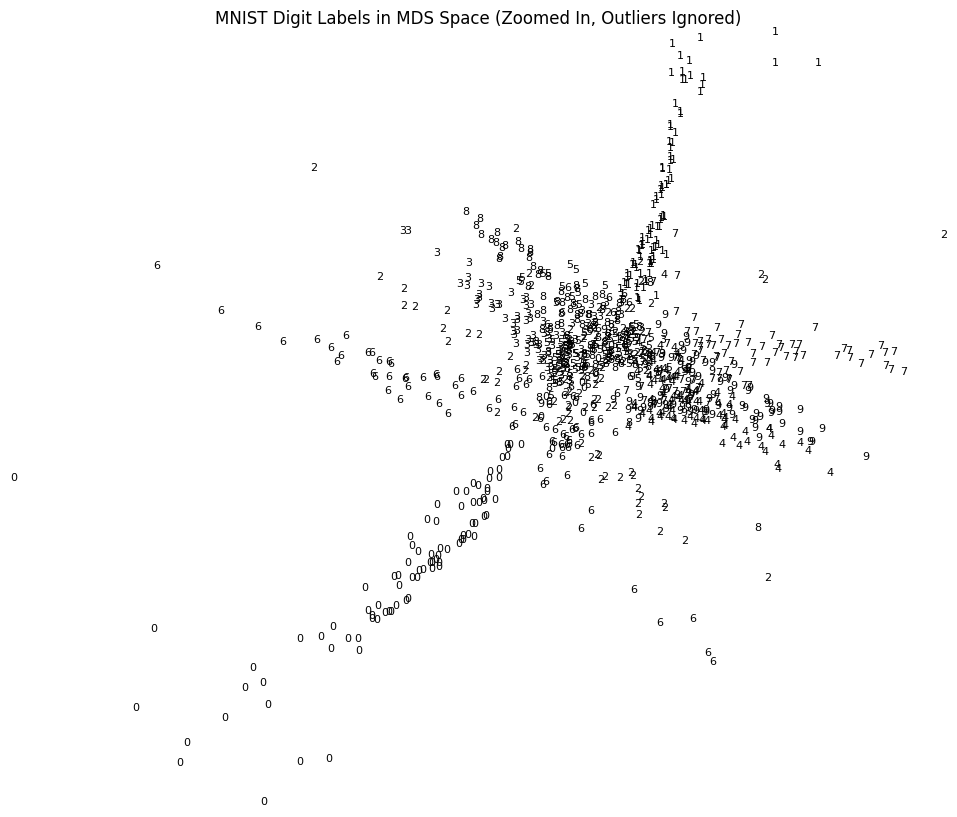

In [41]:
# Step 1: Calculate distances from the mean (or median) of all points
center = np.mean(transformed_points, axis=0)
distances = np.linalg.norm(transformed_points - center, axis=1)

# Step 2: Find the indices of the 10 most distant points
outlier_indices = np.argsort(distances)[-10:]

# Step 3: Get the mask of inliers (non-outliers)
mask = np.ones(len(transformed_points), dtype=bool)
mask[outlier_indices] = False

# Step 4: Get the non-outlier (central cluster) points
inlier_points = transformed_points[mask]

# Plot with zoom-in
fig, ax = plt.subplots(figsize=(12, 10))
for i in np.where(mask)[0]:
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(correct[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

# Set axis limits based on inlier points
ax.set_xlim(inlier_points[:, 0].min(), inlier_points[:, 0].max())
ax.set_ylim(inlier_points[:, 1].min(), inlier_points[:, 1].max())

plt.axis('off')
plt.title("MNIST Digit Labels in MDS Space (Zoomed In, Outliers Ignored)")
plt.show()

In [42]:
def plot_mds_digits(selected_digits, voltages, data, correct, n_outliers=10, alpha_actual=1, percent_size=0.02):
    # Step 0: Filter for selected digits
    voltages = np.array(voltages)
    
    indices = [i for i, label in enumerate(correct) if label in selected_digits]
    filtered_voltages = voltages[np.ix_(selected_digits, indices)]
    points = np.array(list(map(list, zip(*filtered_voltages))))

    print(filtered_voltages.shape)
    print(points.shape)

    filtered_data = np.array([data[i] for i in indices])
    filtered_labels = np.array([correct[i] for i in indices])

    print(filtered_data.shape)
    
    # Step 1: Run MDS on voltages    
    mds = MDS(n_components=2, random_state=42)
    transformed_points = mds.fit_transform(points)

    print(transformed_points.shape)
    
    # Step 2: Remove outliers
    center = np.mean(transformed_points, axis=0)
    distances = np.linalg.norm(transformed_points - center, axis=1)
    outlier_indices = np.argsort(distances)[-len(selected_digits):]
    mask = np.ones(len(transformed_points), dtype=bool)
    mask[outlier_indices] = False
    inlier_points = transformed_points[mask]
    
    # Step 3: Plot MNIST images with colored alpha
    fig, ax = plt.subplots(figsize=(12, 10))

    # Assign distinct colors for each digit
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
    
    digit_colors = {}

    for i, label in enumerate(selected_digits):
        digit_colors[label] = colors[i]

    x_bound = (inlier_points[:, 0].min(), inlier_points[:, 0].max())
    y_bound = (inlier_points[:, 1].min(), inlier_points[:, 1].max())

    image_size = (x_bound[1] + y_bound[1] - x_bound[0] - y_bound[0]) * percent_size / 2
    
    for i in np.where(mask)[0]:
        alpha_mask = np.clip(filtered_data[i].reshape(28, 28) / 255.0, 0, 1)

        label = filtered_labels[i]
        color = np.array(digit_colors[label])
        
        # Create RGBA image
        rgb_image = np.zeros((28, 28, 4))
        for c in range(3):
            rgb_image[..., c] = color[c]
        rgb_image[..., 3] = alpha_mask * alpha_actual  # Alpha from pixel intensity

        x, y = transformed_points[i]
        ax.imshow(rgb_image, extent=(x - image_size, x + image_size, y - image_size, y + image_size), origin='upper')
    
    ax.set_xlim(x_bound[0] - image_size, x_bound[1] + image_size)
    ax.set_ylim(y_bound[0] - image_size, y_bound[1] + image_size)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    plt.title("MDS Visualization of Digits: " + ", ".join(map(str, selected_digits)))
    plt.show()

(7, 700)
(700, 7)
(700, 784)
(700, 2)


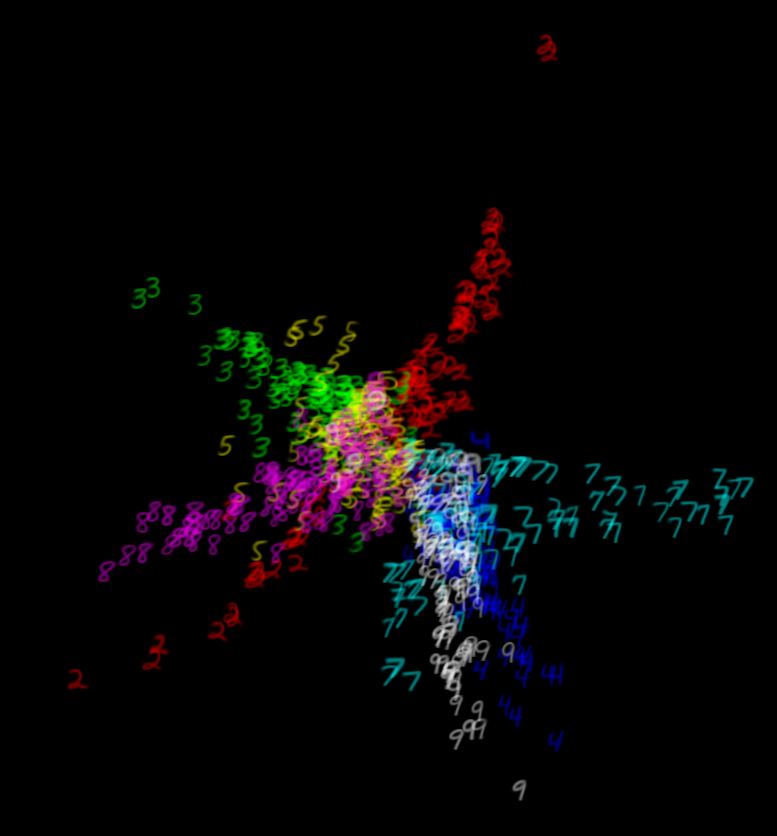

In [43]:
plot_mds_digits([2, 3, 4, 5, 7, 8, 9], voltages, data, correct, alpha_actual=0.5)

(2, 200)
(200, 2)
(200, 784)
(200, 2)


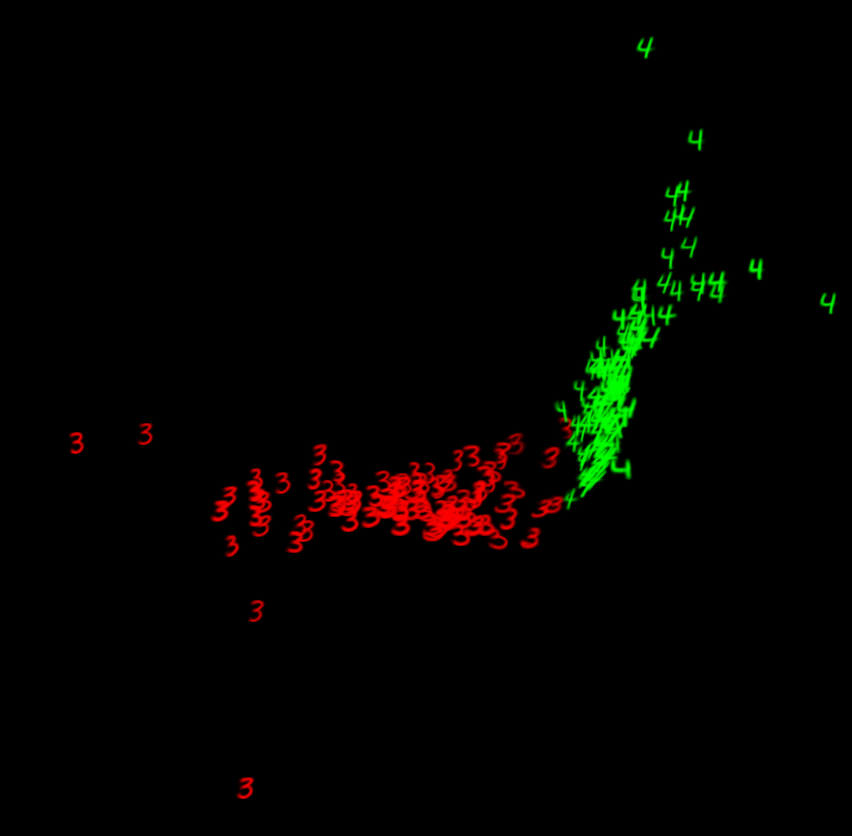

In [44]:
plot_mds_digits([3, 4], voltages, data, correct)

(3, 300)
(300, 3)
(300, 784)
(300, 2)


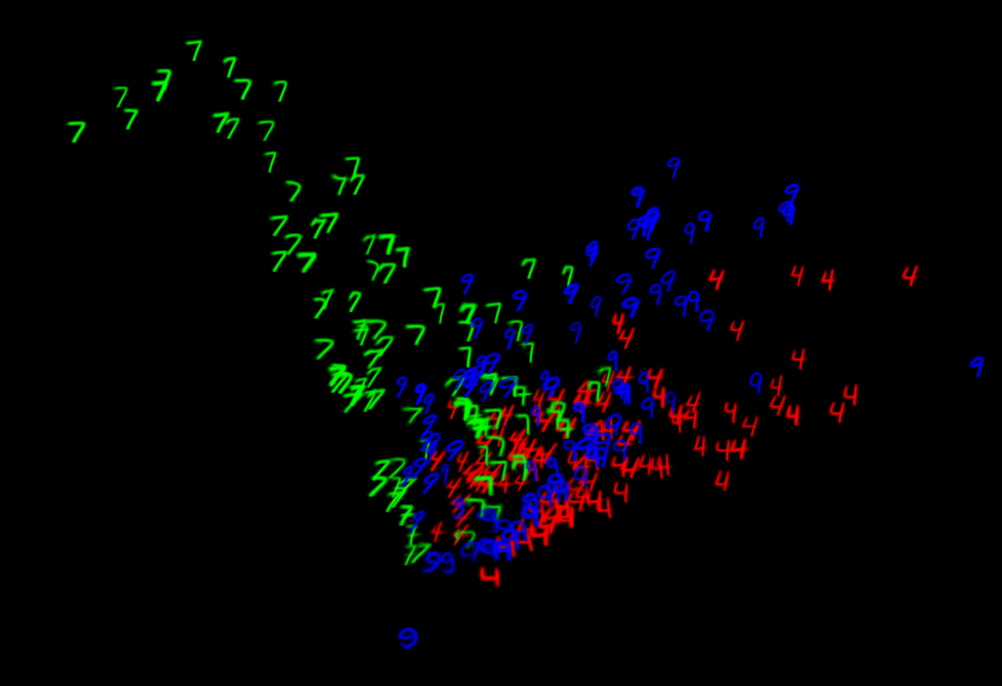

In [45]:
plot_mds_digits([4, 7, 9], voltages, data, correct)